# Gaussian Processes - A no-skip-math version
> End-to-end math derivations for Gaussian process regression and classification

- toc: true 
- badges: true
- comments: true
- author: Zeel B Patel
- categories: [ML]

In [35]:
import jax
import jax.numpy as jnp

from tinygp.kernels import ExpSquared

import matplotlib.pyplot as plt

## Regression

In this post, we will consider the regression problem of finding a reasonable map $X \to \boldsymbol{y}$ along with uncertainty. We can do this in a simplest setting with Bayesian linear regression assuming a **M**ulti**V**ariate **N**ormal (MVN) prior $\boldsymbol{\theta} \sim \mathcal{N}(\boldsymbol{\mu}_\theta, \Sigma_\theta)$ (why MVN? because $\theta \in (-\infty, \infty)$) and Normal likelihood $y \sim \mathcal{N}(\boldsymbol{x}^T\theta, \sigma_n^2)$ with i.i.d. assumption.

To start with Gaussian process regression, let us first focus on $\boldsymbol{y}$ (and ignore $X$). We assume $\boldsymbol{f}$ as a random variable and $\boldsymbol{y}$ as a realization of $\boldsymbol{f}$ with some noise. It would be a natural probabilistic assumption to assume $\boldsymbol{f}$ to be MVN distributed since its range is $(-\infty, \infty)$. 

\begin{equation}
p(\boldsymbol{f}) \sim \mathcal{N}(\boldsymbol{m}_f, K_{ff})
\tag{prior}
\end{equation}

Now, we need to bring in $X$ in a reasonable way to this formulation. A core assumption connecting $X$ with $\boldsymbol{y}$ is the following:
> if two inputs $\boldsymbol{x}$ and $\boldsymbol{x}'$ are close to each other (how to define the closeness? kernels!), corresponding $\boldsymbol{y}$ and $\boldsymbol{y}'$ are likely to be similar.

We use something known as covariance function or kernel (later is more prevalent) to define this closeness. For example, RBF or squared exponential is a well-known kernel:

\begin{equation}
k_{RBF}(\boldsymbol{x}, \boldsymbol{x}') = \sigma^2 \exp \left(-{\frac {\|\boldsymbol{x} -\boldsymbol{x}' \|^{2}}{2\ell ^{2}}}\right)
\tag{kernel}
\end{equation}

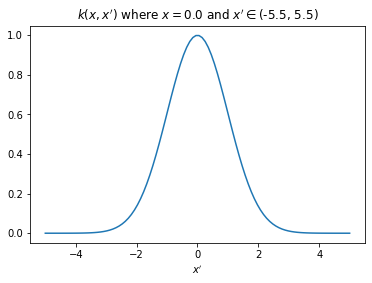

In [34]:
x = jnp.array(0.0).reshape(1, 1)
x_prime = jnp.linspace(-5,5,100).reshape(-1, 1)

plt.plot(x_prime, ExpSquared()(x_prime, x));
plt.xlabel("$x'$")
plt.title(f"$k(x,x')$ where $x={x[0][0]}$ and $x' \in ${plt.xlim()}");

The plot above shows that value of $k(\boldsymbol{x}, \boldsymbol{x}')$ increases as $\boldsymbol{x}'$ approaches $\boldsymbol{x}$ and reduces as it moves far from $\boldsymbol{x}$. Now, we will connect $X$ with $\boldsymbol{f}$ (and thus with $\boldsymbol{y}$) through kernel $k$ with two following assumptions:

1. Diagonal entries of $K_{ff}$ represent variance of $f_i$, which can be represented by $k(\boldsymbol{x}_i, \boldsymbol{x}_i)$.
2. Non-diagonal entries of $K_{ff}$ represent covariance between $f_i$ and $f_j$ and can be represented by $k(\boldsymbol{x}_i, \boldsymbol{x}_j)$.

At this point, we have made everything clear about prior $p(\boldsymbol{f}) \sim \mathcal{N}(\boldsymbol{m}_f, K_{ff})$. Now, we will look at the likelihood. As mentioned earlier, $\boldsymbol{y}$ is noisy realization of $f$ so the following likelihood would be a simple and natural choice.

\begin{equation}
p(\boldsymbol{y}|\boldsymbol{f}) \sim \mathcal{N}(\boldsymbol{f}, \sigma_n^2I)
\tag{likelihood}
\end{equation}

Till now, we followed bottom-up approach and defined prior and likelihood for this problem. Now we will explore the top-down approach. 

Our ultimate goal is derive $p(\boldsymbol{y}^*|X^*,\boldsymbol{y}, X)$ at new inputs $X^*$. This can be written as:

\begin{equation}
p(\boldsymbol{y}^*|X^*,\boldsymbol{y}, X) = \int p(\boldsymbol{y}^*|\boldsymbol{f}^*)p(\boldsymbol{f}^*|X^*,\boldsymbol{y}, X)d\boldsymbol{f}^*
\tag{pred post new}
\end{equation}

Here, $p(\boldsymbol{f}^*|X^*,\boldsymbol{y}, X)$ is the posterior distribution at inputs $X^*$. Once we derive posterior $p(\boldsymbol{f}|\boldsymbol{y},X)$, We can find $p(\boldsymbol{f}^*|X^*,\boldsymbol{y}, X)$ like following:

\begin{equation}
p(\boldsymbol{f}^*|X^*, \boldsymbol{y}, X) = \int p(\boldsymbol{f}^*|X^*, \boldsymbol{f}, X)p(\boldsymbol{f}|\boldsymbol{y}, X)d\boldsymbol{f}
\tag{post new}
\end{equation}

Here, $p(\boldsymbol{f}^*|X^*, \boldsymbol{f}, X)$ is a [conditional Gaussian distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions) with the following closed form:

\begin{equation}
p(\boldsymbol{f}^*|X^*, \boldsymbol{f}, X) \sim \mathcal{N}(\boldsymbol{m}_{f^*}+K_{f^*f}K_{ff}^{-1}(\boldsymbol{f}-\boldsymbol{m}_{f}), K_{f^*f^*} - K_{f^*f}K_{ff}^{-1}K_{ff^*})
\tag{cond}
\end{equation}

Posterior $p(\boldsymbol{f}|\boldsymbol{y}, X)$ can be derived following "Bayes' rule for Gaussians" (section 2.2.6.2 in [pml book2](https://probml.github.io/pml-book/book2.html)):

\begin{equation}
p(\boldsymbol{f}|\boldsymbol{y}, X) \sim \mathcal{N}(\boldsymbol{m}_f + K_{ff}\left(K_{ff}+\sigma_n^2I\right)^{-1}(\boldsymbol{y} - \boldsymbol{m}_f), K_{ff} - K_{ff}\left(K_{ff} + \sigma_n^2I\right)^{-1}K_{ff})
\tag{post}
\end{equation}

We can now substitute Eq. (post) and Eq. (cond) in Eq. (post new). The integral can be solved with using Eq. 2.90 in section 2.2.6.2 in [pml book2](https://probml.github.io/pml-book/book2.html) and also mentioned in Eq. (int gaussians) in Appendix.

\begin{align}
p(\boldsymbol{f}^*|X^*, \boldsymbol{y}, X) &\sim \mathcal{N}(\boldsymbol{\mu}^*, \Sigma^*)\\
\boldsymbol{\mu}^* &= \boldsymbol{m}_{f^*}+K_{f^*f}K_{ff}^{-1}(\left[\boldsymbol{m}_f + K_{ff}\left(K_{ff}+\sigma_n^2I\right)^{-1}(\boldsymbol{y} - \boldsymbol{m}_f)\right]-\boldsymbol{m}_{f})\\
&=\boldsymbol{m}_{f^*}+K_{f^*f}K_{ff}^{-1}(K_{ff}\left(K_{ff}+\sigma_n^2I\right)^{-1}(\boldsymbol{y} - \boldsymbol{m}_f))\\
&=\boldsymbol{m}_{f^*}+K_{f^*f}\left(K_{ff}+\sigma_n^2I\right)^{-1}(\boldsymbol{y} - \boldsymbol{m}_f)\\
\\
\Sigma^* &= K_{f^*f^*} - K_{f^*f}K_{ff}^{-1}K_{ff^*} + K_{f^*f}K_{ff}^{-1}\left[K_{ff} - K_{ff}\left(K_{ff} + \sigma_n^2I\right)^{-1}K_{ff}\right]K_{ff}^{-1}K_{ff^*}\\
&=K_{f^*f^*} - K_{f^*f}K_{ff}^{-1}K_{ff^*} + K_{f^*f}\left[I - \left(K_{ff} + \sigma_n^2I\right)^{-1}K_{ff}\right]K_{ff}^{-1}K_{ff^*}\\
&=K_{f^*f^*} - K_{f^*f}K_{ff}^{-1}K_{ff^*} + K_{f^*f}\left[K_{ff}^{-1} - \left(K_{ff} + \sigma_n^2I\right)^{-1}\right]K_{ff^*}\\
&=K_{f^*f^*} - K_{f^*f}K_{ff}^{-1}K_{ff^*} + K_{f^*f}K_{ff}^{-1}K_{ff^*} - K_{f^*f}\left(K_{ff} + \sigma_n^2I\right)^{-1}K_{ff^*}\\
&=K_{f^*f^*} - K_{f^*f}\left(K_{ff} + \sigma_n^2I\right)^{-1}K_{ff^*}\\
p(\boldsymbol{f}^*|X^*, \boldsymbol{y}, X) &\sim \mathcal{N}(\boldsymbol{m}_{f^*}+K_{f^*f}\left(K_{ff}+\sigma_n^2I\right)^{-1}(\boldsymbol{y} - \boldsymbol{m}_f), K_{f^*f^*} - K_{f^*f}\left(K_{ff} + \sigma_n^2I\right)^{-1}K_{ff^*})
\end{align}

Now, we are almost there. Plugging in the above formula in Eq. (pred post) and using known result in Eq. (int gaussians), we get the predictive posterior as following:

\begin{equation}
p(\boldsymbol{y}^*|X^*,\boldsymbol{y}, X) \sim \mathcal{N}(\boldsymbol{m}_{f^*}+K_{f^*f}\left(K_{ff}+\sigma_n^2I\right)^{-1}(\boldsymbol{y} - \boldsymbol{m}_f), K_{f^*f^*} - K_{f^*f}\left(K_{ff} + \sigma_n^2I\right)^{-1}K_{ff^*} + \sigma_n^2I)
\end{equation}

> Note: We did not exploit the special structure of likelihood variance $\sigma_n^2I$ anywhere, so, these derivations hold true for full rank likelihood covariance matrices also.

### Optimization

We perform type-II likelihood estimation (in other words, minimize log marginal likelihood or evidence term). Our goal is to find optimal model $\mathcal{M}$ represented by prior (or kernel) hyperparameters and likelihood hyperparameters. We can get the log marginal likelihood using Eq. (int gaussians):

\begin{align}
p(\boldsymbol{y}|X, \mathcal{M}) &= \int p(\boldsymbol{y}|\boldsymbol{f}) p(\boldsymbol{f})d\boldsymbol{f}\\
&\sim \int \mathcal{N}(\boldsymbol{y}|\boldsymbol{f}, \sigma_n^2I) \mathcal{N}(\boldsymbol{f}|\boldsymbol{m}_f, K_{ff})\\
&\sim \mathcal{N}(\boldsymbol{y}|\boldsymbol{m}_f, K_{ff}+\sigma_n^2I)
\end{align}

For case of RBF kernel, $\mathcal{M}$ parameters will be $\{\sigma, \ell, \sigma_n\}$.

## Classification (with Laplace approximation)

We will derive a GP predictive posterior for binary case only because for multi-class, it gets a bit complex. Our assumption for prior over the $\boldsymbol{f}$ can still be the same but likelihood needs to be changed because $\boldsymbol{y}$ is no more a real number but rather a binary value e.g. 0 or 1. From Bayesian point-of-view, Bernoulli likelihood would be the most appropriate as a likelihood here:

\begin{equation}
p(\boldsymbol{y}|\boldsymbol{f}) = \prod_{i=1}^{N} \sigma(f_i)^{y_i=1}(1-\sigma(f_i))^{y_i=0}
\tag{class likelihood}
\end{equation}

Since, MVN prior and Bernoulli likelihood are not conjugate, we need to use an approximate method of inference here. We use Laplace approximation to get the MAP estimate $\boldsymbol{\hat{f}}$ and by computing the Hessian $H$ of negative log joint (log prior + log likelihood) with respect to $\boldsymbol{\hat{f}}$, we can get the posterior distribution as the following:

\begin{equation}
p(\boldsymbol{f}|\boldsymbol{y}, X) \sim \mathcal{N}(\boldsymbol{\hat{f}}, H^{-1})
\tag{class post}
\end{equation}

Eq. (cond) will be the same in this case, and thus, we can solve Eq. (post new) as we did for regression case, like the following:

\begin{equation}
p(\boldsymbol{f}^*|X^*, \boldsymbol{y}, X) \sim \mathcal{N}(\boldsymbol{m}_{f^*}+K_{f^*f}K_{ff}^{-1}(\boldsymbol{\hat{f}}-\boldsymbol{m}_{f}), K_{f^*f^*} - K_{f^*f}K_{ff}^{-1}K_{ff^*} + K_{f^*f}K_{ff}^{-1}H^{-1}K_{ff}^{-1}K_{ff^*})
\end{equation}

### Optimization

To perform Type-II likelihood estimation for binary classification, we first need to derive the log marginal likelihood which can be approximated with Laplace approximation. First, we define the following quantity:

\begin{equation}
\boldsymbol{\psi}(\boldsymbol{f}) \triangleq \log p(\boldsymbol{y}|\boldsymbol{f}) + \log p(\boldsymbol{f})
\end{equation}

Now, computing the log marginal likelihood as suggested in section 3.4.4 of [GPML book](https://gaussianprocess.org/gpml/chapters/RW.pdf):

\begin{align}
\log p(\boldsymbol{y}|X, \mathcal{M}) &\sim \int p(\boldsymbol{y}|\boldsymbol{f}) p(\boldsymbol{f})d\boldsymbol{f}\\
&= \log \int \exp\left(\boldsymbol{\psi}(\boldsymbol{f})\right)d\boldsymbol{f}\\
&\thickapprox \log \int \exp\left(\boldsymbol{\psi}(\boldsymbol{\hat{f}}) -\frac{1}{2}(\mathbf{f}-\hat{\mathbf{f}})^{\top} H(\mathbf{f}-\hat{\mathbf{f}})\right)d\boldsymbol{f}\\
&= \log \exp \boldsymbol{\psi}(\boldsymbol{\hat{f}}) \int exp\left(-\frac{1}{2}(\mathbf{f}-\hat{\mathbf{f}})^{\top} H(\mathbf{f}-\hat{\mathbf{f}})\right)d\boldsymbol{f}\\
&= \log p(\boldsymbol{y}|\boldsymbol{\hat{f}}) + \log p(\boldsymbol{\hat{f}}) - \frac{N}{2}\log(2\pi) - \frac{1}{2}\log|H^{-1}|\\
&= \log p(\boldsymbol{y}|\boldsymbol{\hat{f}}) -\frac{1}{2}\boldsymbol{\hat{f}}^TK_{ff}^{-1}\boldsymbol{\hat{f}} - \frac{1}{2}\log|K_{ff}| - \frac{N}{2}\log(2\pi) - \frac{1}{2}\log|H^{-1}| - \frac{N}{2}\log(2\pi)
\end{align}

Our final optimization algorithm would be as following:
1. For N iterations do 2. to 4.
2. Optimize for $\boldsymbol{\hat{f}}$ with M iterations using standard MAP estimation (maybe use non-centered parametrization).
3. Compute gradient of parameters of $\mathcal{M}$ w.r.t. log marginal likelihood
4. Update parameters of $\mathcal{M}$.

## Appendix

\begin{equation}
\int \mathcal{N}(\boldsymbol{y}|W\boldsymbol{x}+\boldsymbol{b}, \Sigma) \mathcal{N}(\boldsymbol{x}|\boldsymbol{\mu}, K) = \mathcal{N}(\boldsymbol{y}|W\boldsymbol{\mu}+b, WKW^T+\Sigma)
\tag{int gaussians}
\end{equation}